## ЗАДАНИЕ:
    - Решите уже знакомую задачу регрессии — предсказание цены на недвижимость. Датасет — train.csv;
    - Используйте objective = "reg:linear" в xgboost;
    - Настройте гиперпараметры, используя hyperopt либо ручную настройку (как вам больше нравится);
    - Используйте отложенную выборку (как на занятии), чтобы следить за процессом обучения xgboost'а,но — как и в предыдущем домашнем задании — финальную оценку качества давайте, используя 10-fold кросс-валидацию;
    - Проанализируйте, насколько согласованы оценка на отложенной выборке и на кросс-валидации (одновременно уменьшаются/увеличиваются при изменении гиперпараметров или ведут себя по-разному);
    - Проанализируйте признаки, используя XGBFI, сделайте выводы об интересных взаимодействиях;

In [10]:
#conda install -c anaconda py-xgboost

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

import tqdm
import missingno as mn

# Visualization libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

palette = sns.hls_palette(8, l=0.7, s=.8)
sns.set(rc={"figure.figsize": (6, 6)}, palette=palette)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (10, 5)

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

## Подготовка данных

In [11]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

y_df = train_data.SalePrice
train_data.drop('SalePrice', axis=1, inplace=True)

labels = {}

In [12]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


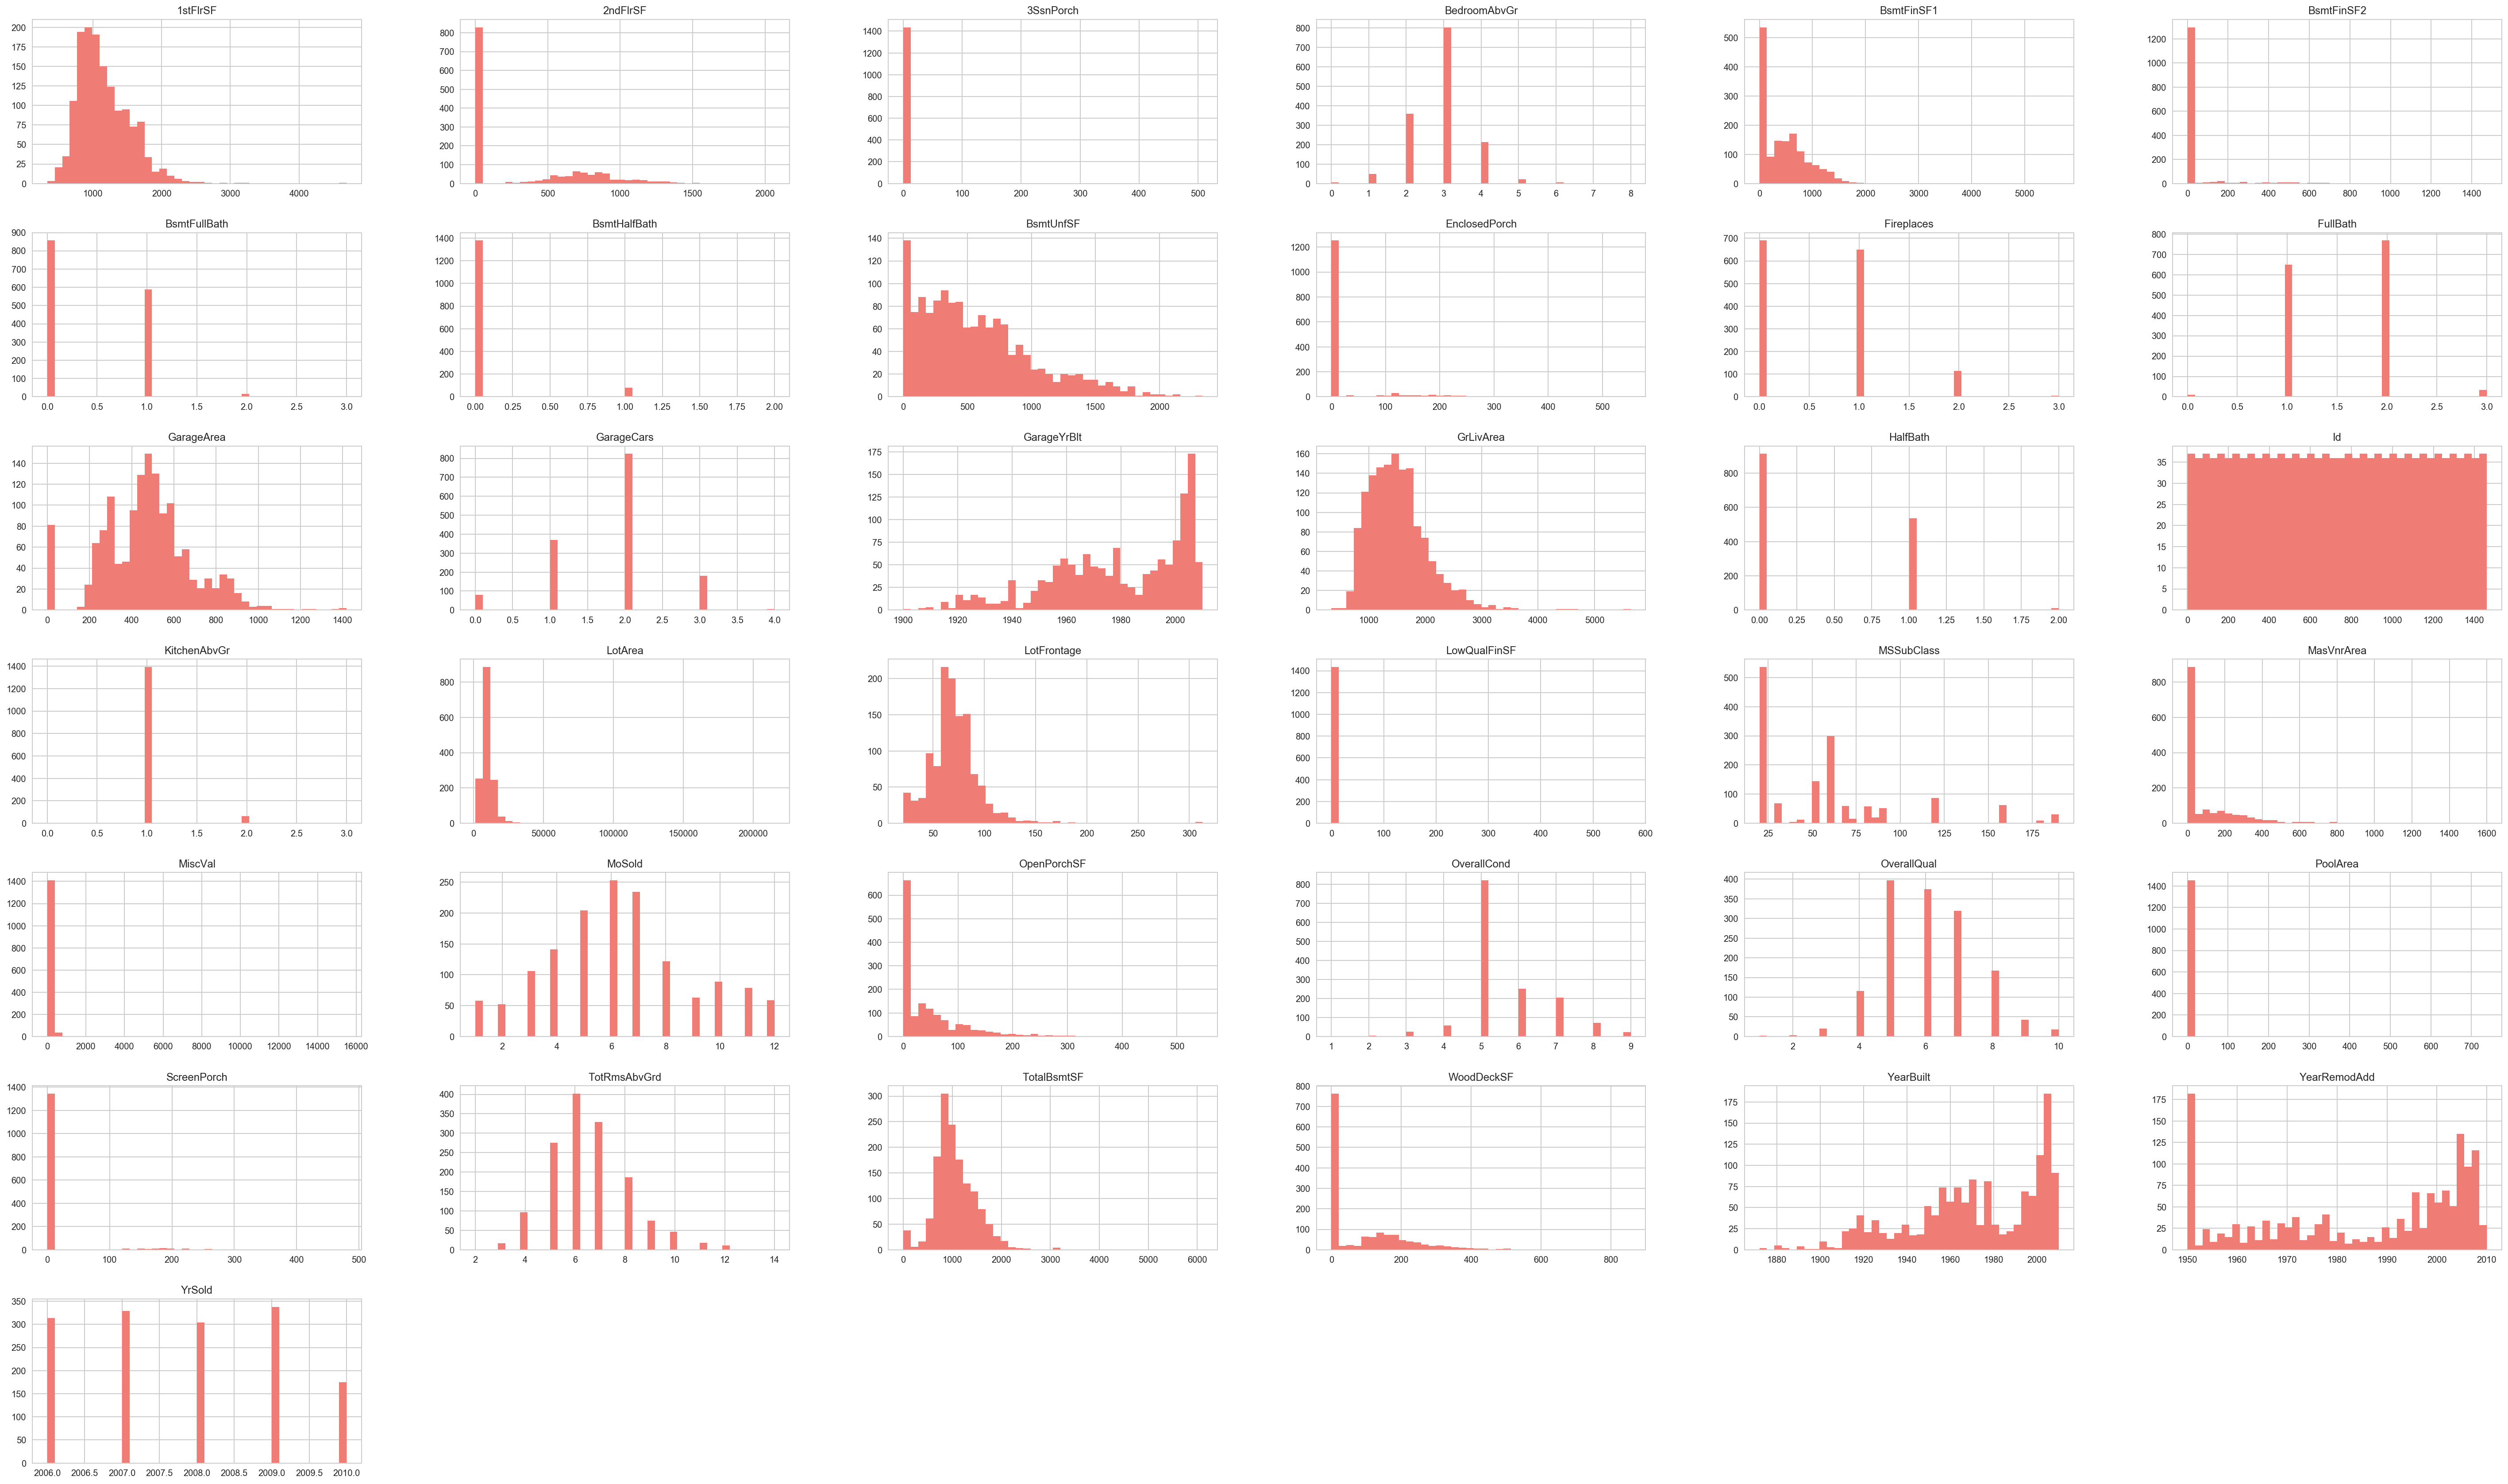

In [13]:
xfig = train_data.hist(bins=40, figsize=(50,30))

In [14]:

def spl_datasets(df):
    train = df[df['is_test'] == 0].drop('is_test', axis=1)
    test = df[df['is_test'] == 1].drop('is_test', axis=1)
    return (train, test)

def prepr_datasets(df):
    cat_features = []
    set_features = (
        'MSSubClass', 'MSZoning', 'Street',
        'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope',
        'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle',
        'OverallQual', 'OverallCond',
        'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType',
        'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', 'KitchenQual', 'Functional',
        'FireplaceQu', 'GarageType', 'GarageFinish',
        'GarageQual', 'GarageCond', 'PavedDrive',
        'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
        'SaleCondition'
    )
    fill_zeroes = (
        'MasVnrArea', 'GarageCars',
        'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF',
        'BsmtFullBath', 'BsmtHalfBath',
        'GarageArea'
    )
    
    for col in cat_features:
        df[col] = df[col].astype(str)

    for col in set_features:
        label = LabelEncoder()
        labels[col] = label
        values = list(df[col].values)
        label.fit(values)
        df[col] = label.transform(values)
    
    for col in fill_zeroes:
        df[col] = df[col].fillna(0)

    features_to_drop = ['Id', 'LotFrontage', 'GarageYrBlt']

    return df.drop(features_to_drop, axis=1)

def conc_datasets(train, test):
    trn = train.copy()
    tst = test.copy()
    trn['is_test'] = 0
    tst['is_test'] = 1
    return pd.concat([trn, tst])

In [15]:
df = conc_datasets(train_data, test_data)
df = prepr_datasets(df)
X, X_test = spl_datasets(df)


X_train, X_test, y_train, y_test = train_test_split(X, y_df, test_size=0.3, random_state=42, shuffle=True)

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## RandomForest

In [18]:
msle_scores = pd.Series()

def find_params(clf, param_grid, scoring='neg_mean_squared_error', n_iter=50, fit_params={}):
    clf_grid = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring=scoring, 
        random_state=42, 
        n_iter=n_iter, 

    )
    clf_grid.fit(X_train, y_train, **fit_params)

    best_params = clf_grid.best_estimator_.named_steps['reg'].get_params()
    best_score = -clf_grid.best_score_
    msle_scores[clf_grid.best_estimator_.named_steps['reg'].__class__.__name__] = -clf_grid.score(X_test, y_test)
    print(clf_grid.best_estimator_.named_steps['reg'].__class__.__name__)

    print('Best params: {}'.format(best_params))
    print('MSLE (cv): {}'.format(best_score))
    print('MSLE (train): {}'.format(-clf_grid.score(X_train, y_train)))
    print('MSLE (test): {}'.format(-clf_grid.score(X_test, y_test)))
    return clf_grid.best_estimator_.named_steps['reg'], best_params

In [19]:
rf_pipe = Pipeline([

    ('reg', RandomForestRegressor(random_state=40))
])
rf_params = {    

        'reg__bootstrap': [True, False],
        'reg__n_estimators': [50],
        'reg__max_features': uniform(loc=0.1, scale=0.9),
        'reg__max_depth': randint(low=1, high=20),
        'reg__min_samples_leaf': randint(low=5, high=20)
}
_, best_params = find_params(rf_pipe, rf_params, 'neg_mean_squared_error', 50)

RandomForestRegressor
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 12, 'max_features': 0.3266040662428278, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': 1, 'oob_score': False, 'random_state': 40, 'verbose': 0, 'warm_start': False}
MSLE (cv): 1032250509.9907022
MSLE (train): 360787971.8107945
MSLE (test): 798510087.7092123


## XGBoost

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(random_state=42))
])

xgb_params = {    
    'n_estimators': 108, 
    'learning_rate': 0.1,                          
    'max_depth': 8,
    'gamma': 0.25,
    'colsample_bytree': 0.15,
    'min_child_weight': 1.5,                                               
    'reg_alpha': 0.8,
    'reg_lambda': 0.6 ,
    'subsample': 0.6,
    'seed': 42,
    'silent': 1,
}

xgb_reg = xgb.XGBRegressor(objective = 'reg:linear', **xgb_params)
xgb_reg.fit(X_train, y_train, eval_metric='rmse', eval_set=[[X_train, y_train], [X_test, y_test]])
y_pred_xgb_reg = xgb_reg.predict(X_test)
rmse_xgb=rmse(y_test, y_pred_xgb_reg)



[0]	validation_0-rmse:178959	validation_1-rmse:180294
[1]	validation_0-rmse:163127	validation_1-rmse:164900
[2]	validation_0-rmse:148337	validation_1-rmse:150079
[3]	validation_0-rmse:134664	validation_1-rmse:136651
[4]	validation_0-rmse:122681	validation_1-rmse:124756
[5]	validation_0-rmse:112084	validation_1-rmse:114395
[6]	validation_0-rmse:102029	validation_1-rmse:104475
[7]	validation_0-rmse:93316.7	validation_1-rmse:95821.6
[8]	validation_0-rmse:85886.7	validation_1-rmse:88873.7
[9]	validation_0-rmse:79321.2	validation_1-rmse:82612.1
[10]	validation_0-rmse:72679.8	validation_1-rmse:76270
[11]	validation_0-rmse:66797.6	validation_1-rmse:71319.6
[12]	validation_0-rmse:61291	validation_1-rmse:65894.6
[13]	validation_0-rmse:56643.2	validation_1-rmse:61432.6
[14]	validation_0-rmse:52363.1	validation_1-rmse:57545.8
[15]	validation_0-rmse:48064.4	validation_1-rmse:53480.8
[16]	validation_0-rmse:44435.1	validation_1-rmse:50281
[17]	validation_0-rmse:41186.6	validation_1-rmse:47868.1
[18]

NameError: name 'mean_squared_error' is not defined

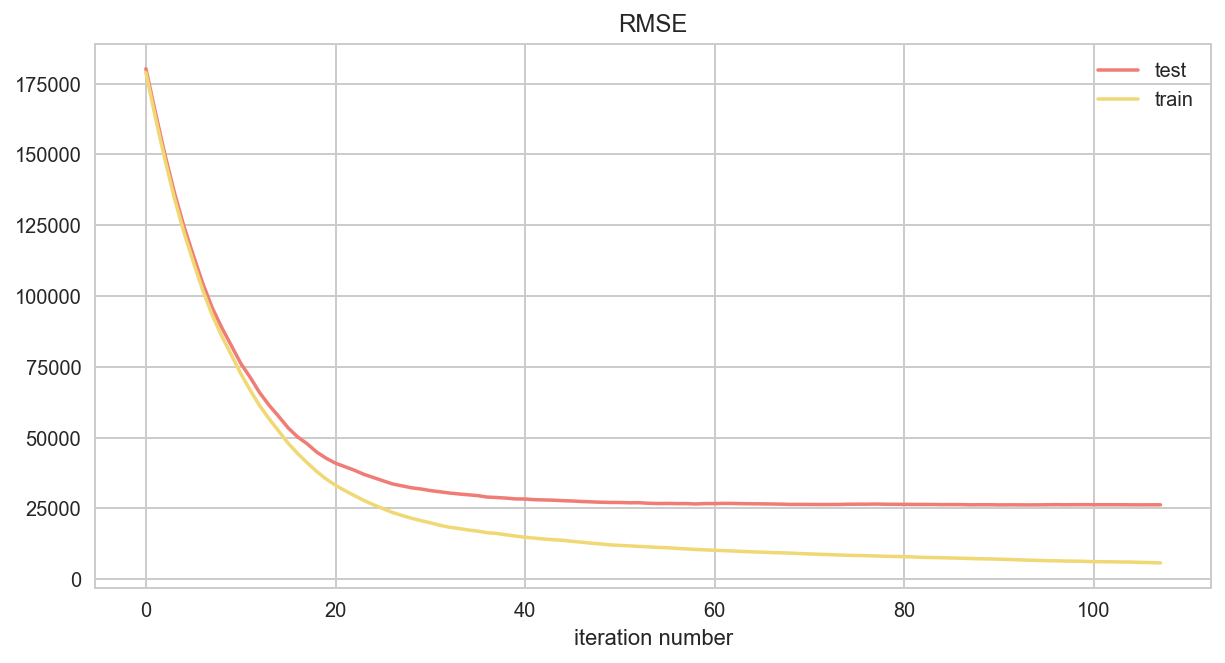

In [21]:
result = pd.DataFrame({'train': xgb_reg.evals_result()['validation_0']['rmse'],
                         'test': xgb_reg.evals_result()['validation_1']['rmse']})

result.plot(title='RMSE')
plt.xlabel('iteration number')
plt.show()

In [23]:
xgb_reg.score(X_train, y_train)



0.9944307632950263

In [24]:
xgb_reg.score(X_test, y_test)

0.9008569300131948

## Hyperopt

In [25]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    reg = xgb.XGBRegressor(**params)
    reg.fit(X_train, y_train)
    y_pred_xgb_test = reg.predict(X_test)
    msle = (np.sum((np.log(y_test) - np.log(np.abs(y_pred_xgb_test)))**2) / y_test.size)
    result = {'loss': msle, 'status': STATUS_OK}
    print('TEST MSLE: {0:.6f}'.format(msle))
    return result


space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 40,
         'learning_rate': 0.1
         }
trials = Trials()
best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)

Training with params :  {'colsample_bytree': 0.75, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
TEST MSLE: 0.018666
Training with params :  {'colsample_bytree': 0.7000000000000001, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 8.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.9, 'n_jobs': -1}
TEST MSLE: 0.017820
Training with params :  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 8.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
TEST MSLE: 0.026171
Training with params :  {'colsample_bytree': 0.9, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.65, 'n_jobs': -1}
TEST MSLE: 0.018156
Training with params :  {'colsample_bytree': 0.55, 'gamma': 0.55, 'learning_rate': 0.1,

Training with params :  {'colsample_bytree': 1.0, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 8.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.5, 'n_jobs': -1}
TEST MSLE: 0.016845
Training with params :  {'colsample_bytree': 0.75, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.8500000000000001, 'n_jobs': -1}
TEST MSLE: 0.018768
Training with params :  {'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 9.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
TEST MSLE: 0.041134
Training with params :  {'colsample_bytree': 0.65, 'gamma': 0.55, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 8.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
TEST MSLE: 0.017844
Training with params :  {'colsample_bytree': 0.8, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 4,

Training with params :  {'colsample_bytree': 0.55, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 9.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.6000000000000001, 'n_jobs': -1}
TEST MSLE: 0.043359
Training with params :  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 9.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
TEST MSLE: 0.017268
Training with params :  {'colsample_bytree': 0.55, 'gamma': 0.75, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 10.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.6000000000000001, 'n_jobs': -1}
TEST MSLE: 0.017411
Training with params :  {'colsample_bytree': 0.7000000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 7.0, 'n_estimators': 40, 'silent': 1, 'subsample': 0.5, 'n_jobs': -1}
TEST MSLE: 0.016699
Training with params :  {'colsample_bytr

In [26]:
xgb_params.update(best)
xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['n_estimators'] = 40

In [27]:
xgb_reg = XGBRegressor(objective = 'reg:linear', **xgb_params)

xgb_reg.fit(X_train, y_train, eval_metric='rmse', eval_set=[[X_train, y_train], [X_test, y_test]])
y_pred_xgb_reg = xgb_reg.predict(X_test)

def score_MSE_log(y, y_pred, **kw):
    r = np.sum((np.log(y) - np.log(np.abs(y_pred)))**2) / y.size
    return r

scoring_string = 'Scoring 10-k-fold on train: {:4f} scoring test: {:4f}'
print('XGB ' + scoring_string.format(
    -cross_val_score(xgb_reg, X_train, y_train, cv=10, scoring=metrics.make_scorer(
        score_MSE_log,
        greater_is_better=False
    )).mean(),
    score_MSE_log(y_test, xgb_reg.fit(X_train, y_train).predict(X_test))
))

[0]	validation_0-rmse:178693	validation_1-rmse:180201
[1]	validation_0-rmse:161976	validation_1-rmse:163696
[2]	validation_0-rmse:147136	validation_1-rmse:149006
[3]	validation_0-rmse:133472	validation_1-rmse:135653
[4]	validation_0-rmse:121221	validation_1-rmse:123548
[5]	validation_0-rmse:110404	validation_1-rmse:112960
[6]	validation_0-rmse:100223	validation_1-rmse:102951
[7]	validation_0-rmse:91296.4	validation_1-rmse:94271.4
[8]	validation_0-rmse:83363.2	validation_1-rmse:86516.1
[9]	validation_0-rmse:76467.9	validation_1-rmse:79702.9
[10]	validation_0-rmse:70172.6	validation_1-rmse:73585.8
[11]	validation_0-rmse:64321	validation_1-rmse:67726.3
[12]	validation_0-rmse:59066.3	validation_1-rmse:62474.7
[13]	validation_0-rmse:54427	validation_1-rmse:57872.2
[14]	validation_0-rmse:50238.6	validation_1-rmse:54186.8
[15]	validation_0-rmse:46371.4	validation_1-rmse:50456
[16]	validation_0-rmse:43012.7	validation_1-rmse:47427.6
[17]	validation_0-rmse:40148.6	validation_1-rmse:44674.4
[18]

## Важность признаков

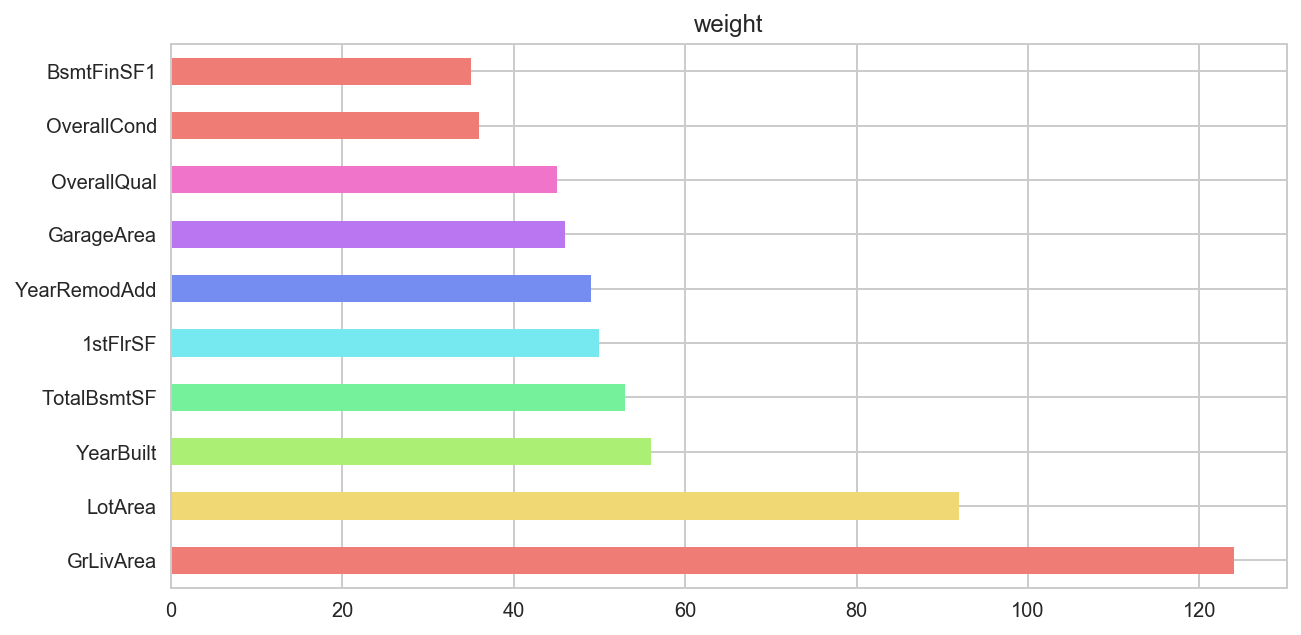

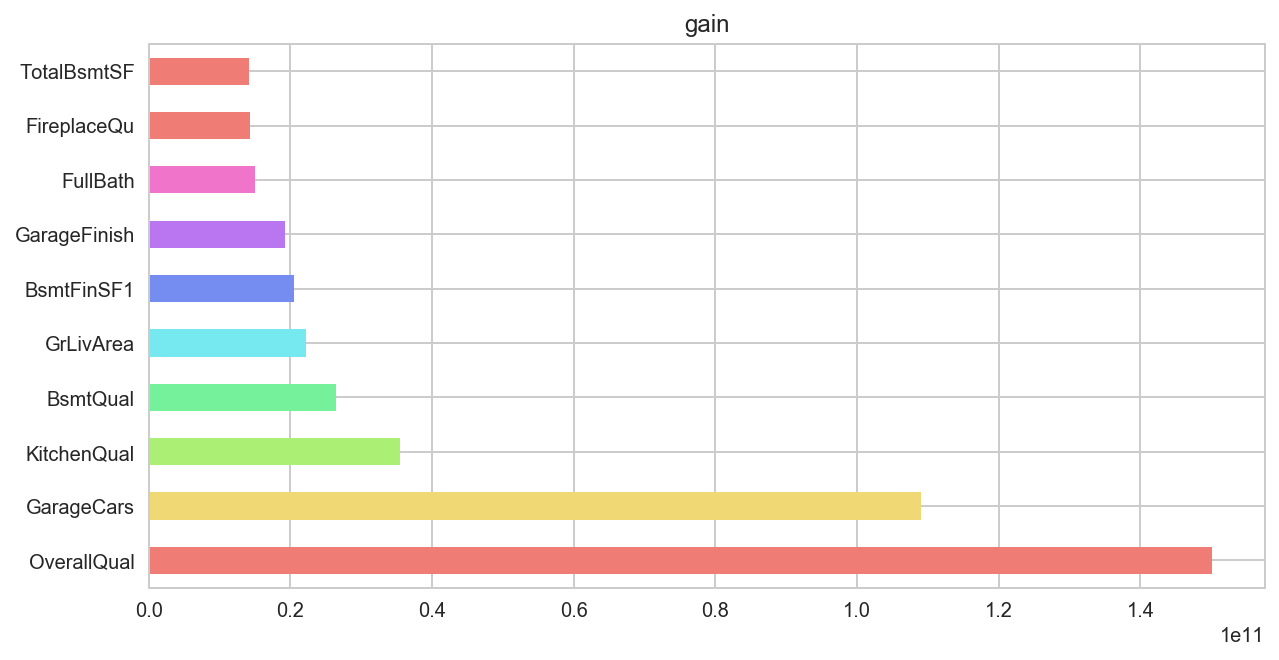

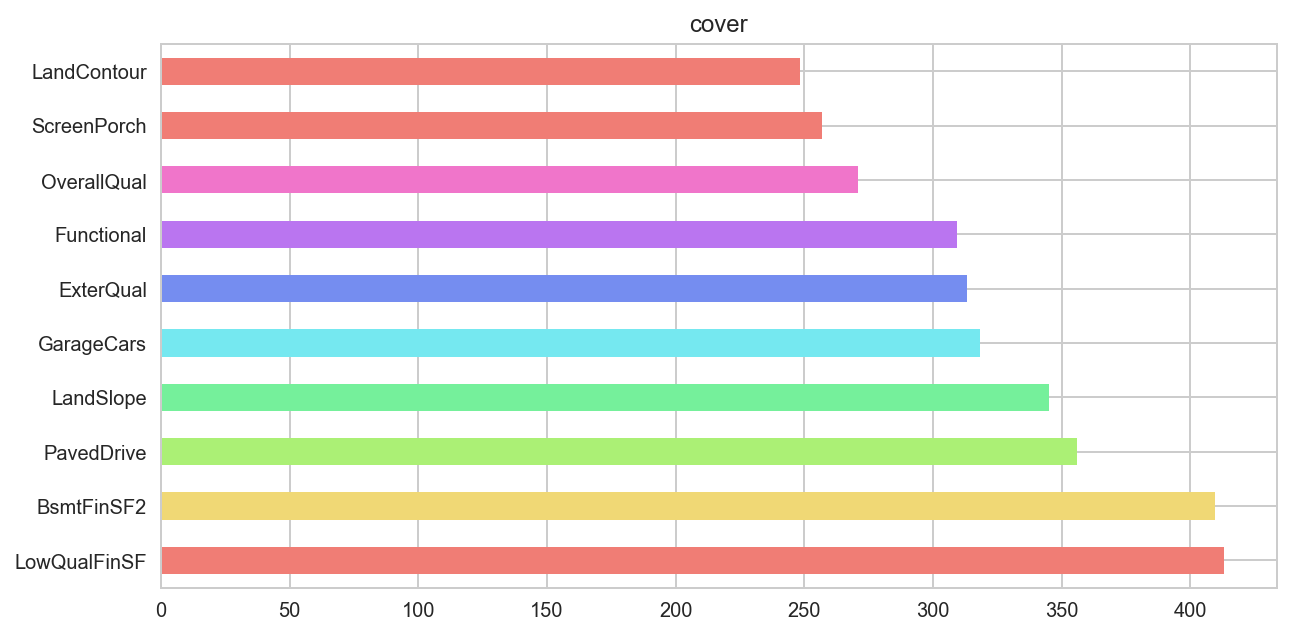

In [28]:
bst = xgb_reg.get_booster()
for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

In [29]:
import xgbfir
xgbfir.saveXgbFI(xgb_reg, OutputXlsxFile='xgbfi_report.xlsx')
xgbfi_results = pd.read_excel('xgbfi_report.xlsx', sheet_name = 'Interaction Depth 0')
xgbfi_results.sort_values(by = 'Gain', ascending = False).head(10)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,OverallQual,6752874214000,45,21.715319,0.482563,1.500639e+11,6.204174e+12,1,8,2,8,1,1,3.500000,13.555556,2.955556
1,GrLivArea,2752869940600,124,31.581340,0.254688,2.220056e+10,1.980711e+12,2,1,1,25,5,2,6.000000,17.443548,4.338710
2,GarageCars,1198620286000,11,6.219109,0.565374,1.089655e+11,1.115553e+12,3,32,14,5,2,3,9.833333,10.090909,1.454545
3,TotalBsmtSF,751171827200,53,14.990265,0.282835,1.417305e+10,2.895323e+11,4,4,5,21,10,5,8.166667,20.018868,4.566038
4,BsmtFinSF1,719846337600,35,8.220423,0.234869,2.056704e+10,3.548052e+11,5,10,10,30,6,4,10.833333,15.057143,4.028571
5,KitchenQual,425868248000,12,4.368098,0.364008,3.548902e+10,1.887506e+11,6,29,21,13,3,8,13.333333,22.250000,4.416667
6,LotArea,418561437600,92,16.684172,0.181350,4.549581e+09,1.052953e+11,7,2,3,39,22,11,14.000000,19.782609,5.163043
7,1stFlrSF,367594907200,50,11.811289,0.236226,7.351898e+09,2.534398e+11,8,5,6,29,14,7,11.500000,21.580000,4.960000
8,BsmtQual,318010316000,12,4.334827,0.361236,2.650086e+10,2.795896e+11,9,30,24,14,4,6,14.500000,20.166667,4.416667
9,GarageArea,284091879520,46,8.756244,0.190353,6.175910e+09,8.187640e+10,10,7,9,38,16,12,15.333333,15.673913,5.195652
